## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft, fftfreq, fftshift, rfft, irfft, ifftshift
import cmath
import binascii
%matplotlib inline

## Read Audio Input

You can use scipy.io.wavefile to read and write a wav file. 
Usually audio file contains two channels (left and right). We will only keep one channel for simplicity. In the code below, "data = data[:,0]" will keep channel 0.

In [26]:
Fs, data = read('Bach2.wav')

data = data[:,0] # keep only one channel of audio instead of both

print("Sampling Frequency is", Fs)
# number of samples
N = data.size 
print("Number of sample is",N)

Sampling Frequency is 44100
Number of sample is 441088


## Play Audio

You can use IPython.display.Audio to play audio.

In [27]:
Audio(data, rate=Fs)

## Plot the wave

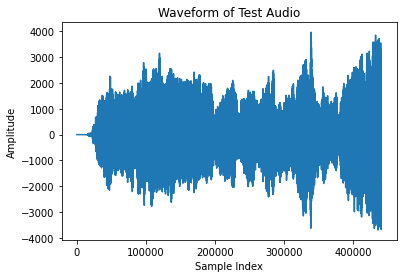

In [28]:
plt.figure()
plt.plot(data)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio')
plt.show()

## Taking FFT and Converting ASCII to Binary

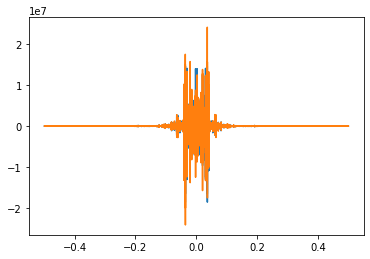

In [29]:
plt.plot(fftfreq(data.size), fft(data).real, fftfreq(data.size), fft(data).imag)

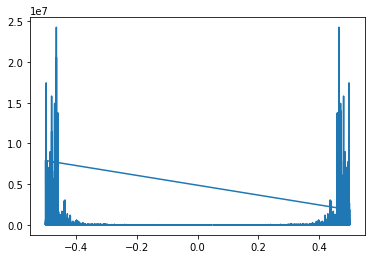

In [6]:
data_ft = fftshift(fft(data, N)) #take real only fft and shift DC level to centre
data_ft_freq = fftfreq(data.size)
plt.plot(data_ft_freq, abs(data_ft))

In [32]:
text_to_embed = "Hello this is an example"

a = bin(int.from_bytes(text_to_embed.encode(), 'big'))
binary_array_to_embed = a[2:]
print(binary_array_to_embed)

10010000110010101101100011011000110111100100000011101000110100001101001011100110010000001101001011100110010000001100001011011100010000001100101011110000110000101101101011100000110110001100101


## Starting embedding

In [33]:
frame = len(binary_array_to_embed) # total length of bits to embed
embed_sample_sz = 10 # number of samples used to embed each bit
p = frame*embed_sample_sz # total number of samples used for embedding data
centre = N/2+1 #centre frequency/ zero point

embedding_freq = 5000 # in hz

X_abs = abs(data_ft) # positive values of fft
X_angle = np.angle(data_ft)# angle of each point in fft

Y = X_abs
X_embed = X_abs[int(centre-embedding_freq-p):int(centre-embedding_freq)]

a = 0.1 # amplification factor of embedding

x_mat = X_embed.reshape(frame, embed_sample_sz) # split by 
x_mat.shape

(191, 10)

### Embedding Algorithm Loop

In [34]:
for k in range(frame):
    avg = 0
    
    for l in range(embed_sample_sz): # take average of 10 samples
        avg = avg+x_mat[k][l]
    avg = avg/embed_sample_sz
    
    if binary_array_to_embed[k] == '0': # bit to encode is '0'
        print('0', end = ' ')
        for l in range(embed_sample_sz):
            x_mat[k][l] = avg # set all 10 samples to same avg value - indicates 0

    else: # when bit is '1'
        print('1', end=' ')
        for l in range(int(embed_sample_sz/2)): # from 0 to 4
            x_mat[k][l] = a*avg # set first half to 0.1*avg
        for l in range(int(embed_sample_sz/2), embed_sample_sz): # 5 to 10
            x_mat[k][l] = (2-a)*avg # 2nd half to 1.9*avg

1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 

### Add embeddings to full fft data

In [35]:
x_vec = x_mat.reshape(p) # bring it back to vector/array

# define range for adding embeddings back to final fft vec with embeddings
range_embed_1 = range(int(centre-embedding_freq-p), int(centre-embedding_freq))
range_embed_2 = range(int(centre+embedding_freq+1), int(centre+embedding_freq+p+1))

Y[range_embed_1] = x_vec
Y[range_embed_2] = x_vec[::-1] # reversed x_vec for symmetry

In [36]:
Y1 = np.multiply(Y, np.exp(1j*X_angle)) # embedded signal with phase information

### Magnitude response after embedding

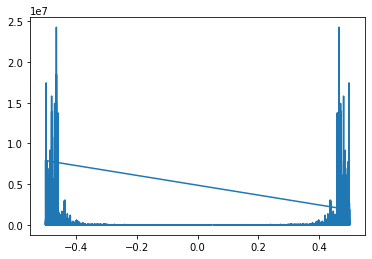

In [37]:
plt.plot(data_ft_freq, abs(Y1))

In [38]:
embedded_signal = ifft(ifftshift(Y1))
embedded_signal

array([   59.85255833+4.02185753j,    58.30587255+5.72397222j,
          56.21810378+7.35531206j, ..., -1489.80482618-1.34230379j,
       -1774.70270069+0.47151117j, -1961.1494371 +2.26537271j])

In [40]:
Audio(embedded_signal.real, rate=Fs)

## Write Audio File

In [15]:
write('output.wav', int(Fs), abs(embedded_signal))

# Recover Encoded Signal

In [41]:
Fs, new_data = read('output.wav')
print("Sampling Frequency is", Fs)
# number of samples
N = data.size 

Sampling Frequency is 44100


In [42]:
Y2 = fftshift(fft(new_data))
required_old_variables = [p, frame, embed_sample_sz, a, embedding_freq] # values that are required to find embedding

In [43]:
Y2_abs = abs(Y2) 
detect_window = Y2_abs[int(centre-embedding_freq-p):int(centre-embedding_freq)] # find in correct frequency window
detect_window_mat = detect_window.reshape(frame, embed_sample_sz) # reshape
recovered_binary = '' # binary string

In [44]:
for k in range(frame):
    avg = 0
    b = 0
    c = 0
    
    for l in range(embed_sample_sz): # find average
        avg = avg+detect_window_mat[k][l]
    avg = avg/embed_sample_sz
    
    # checking first half of frame
    for l in range(int(embed_sample_sz/2)):
        if(detect_window_mat[k][l] >= (1+a)*avg/2): # decision for '0' 
            c = c + 1
        else:
            b = b + 1
    
    # checking second half of the frame
    for l in range(int(embed_sample_sz/2), embed_sample_sz-1):
        if(detect_window_mat[k][l] < (3-a)*avg/2):
            c = c + 1
        else:
            b = b + 1
    
    # final bit decision
    if(b>c):
        recovered_binary = recovered_binary+'1'
    else:
        recovered_binary = recovered_binary+'0'

In [45]:
print(recovered_binary)

00000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [21]:
binary_int = int(recovered_binary+str(1), 2)
binascii.unhexlify('%x' % binary_int)

Error: Odd-length string

In [24]:
whos

Variable                 Type        Data/Info
----------------------------------------------
Audio                    type        <class 'IPython.lib.display.Audio'>
Fs                       int         44100
N                        int         441088
X_abs                    ndarray     441088: 441088 elems, type `float64`, 3528704 bytes (3.365234375 Mb)
X_angle                  ndarray     441088: 441088 elems, type `float64`, 3528704 bytes (3.365234375 Mb)
X_embed                  ndarray     870: 870 elems, type `float64`, 6960 bytes
Y                        ndarray     441088: 441088 elems, type `float64`, 3528704 bytes (3.365234375 Mb)
Y1                       ndarray     441088: 441088 elems, type `complex128`, 7057408 bytes (6.73046875 Mb)
Y2                       ndarray     441088: 441088 elems, type `complex128`, 7057408 bytes (6.73046875 Mb)
Y2_abs                   ndarray     441088: 441088 elems, type `float64`, 3528704 bytes (3.365234375 Mb)
a                        f